<a href="https://colab.research.google.com/github/simulate111/Production-Optimization/blob/main/Circle_Packing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook explains how to install pyomo and solvers. All installations must be done every time you re-open a notebook and want to run it. Google colab has many packages already installed, which you normally would need to install such as nympy, scipy , matplotlib, plotly, pandas. Most of these also comes with Anaconda (except plotly)

Adding text and code is done with "+ Code" or "+ Text" Sections can easlily be moved or deleted. To run a code you need to press the play buttom that appears when you move the cursor over a code block.

First we install pyomo and solvers using an installation provided by idead (using the %%capture magic to not see what is going on). Since you will need to use
Runtime->Run all if you re-define a pyomo model, we add a try-except construction to the Python code to check if pyomo is already installed. The "!" allows us to run command (as in a terminal).


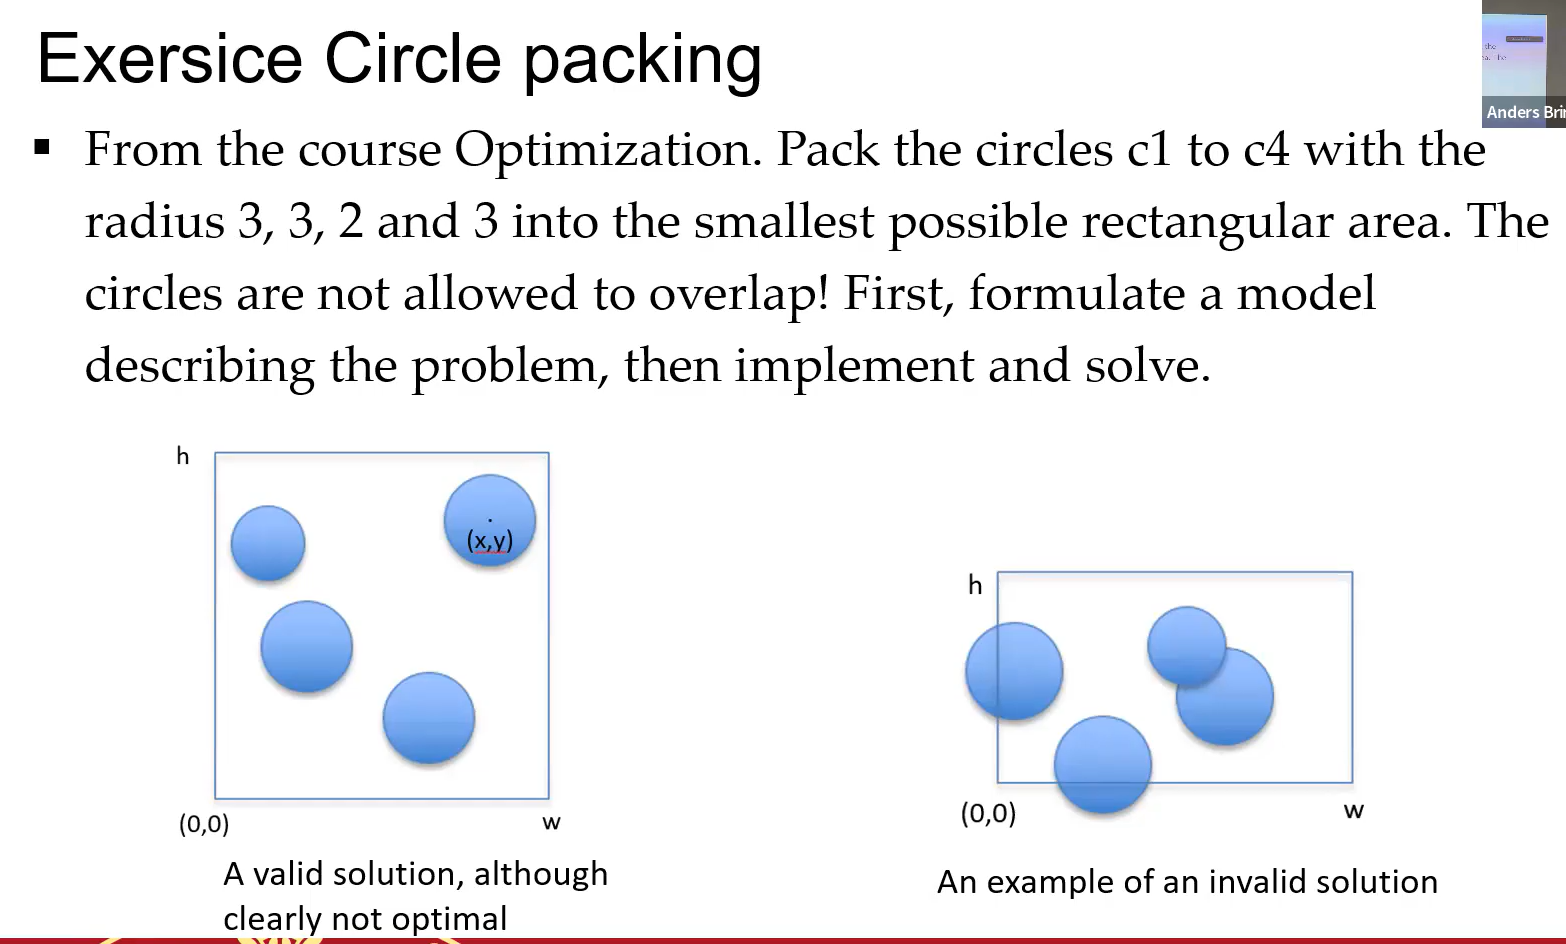

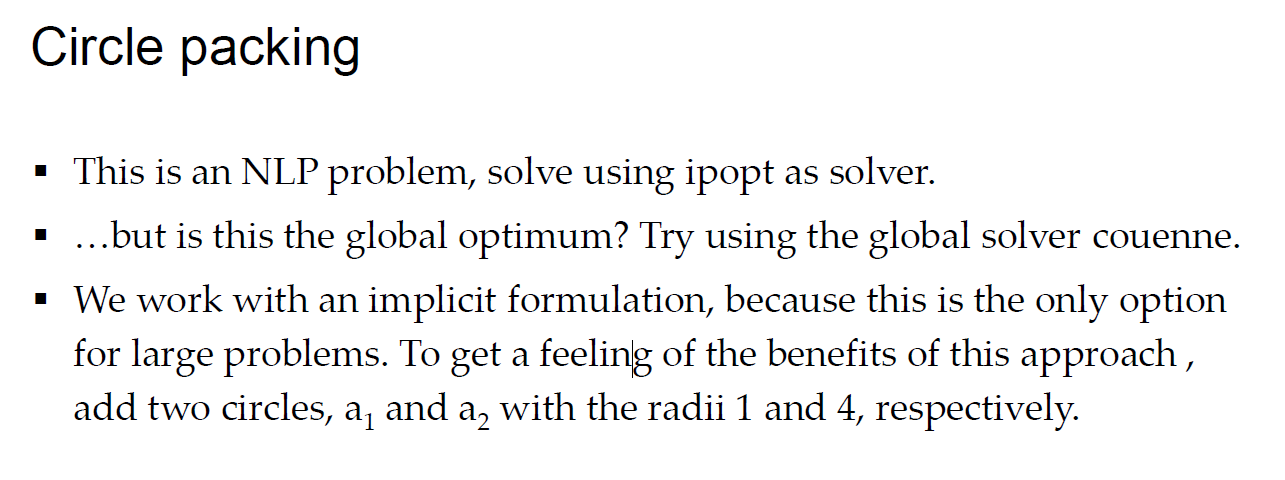

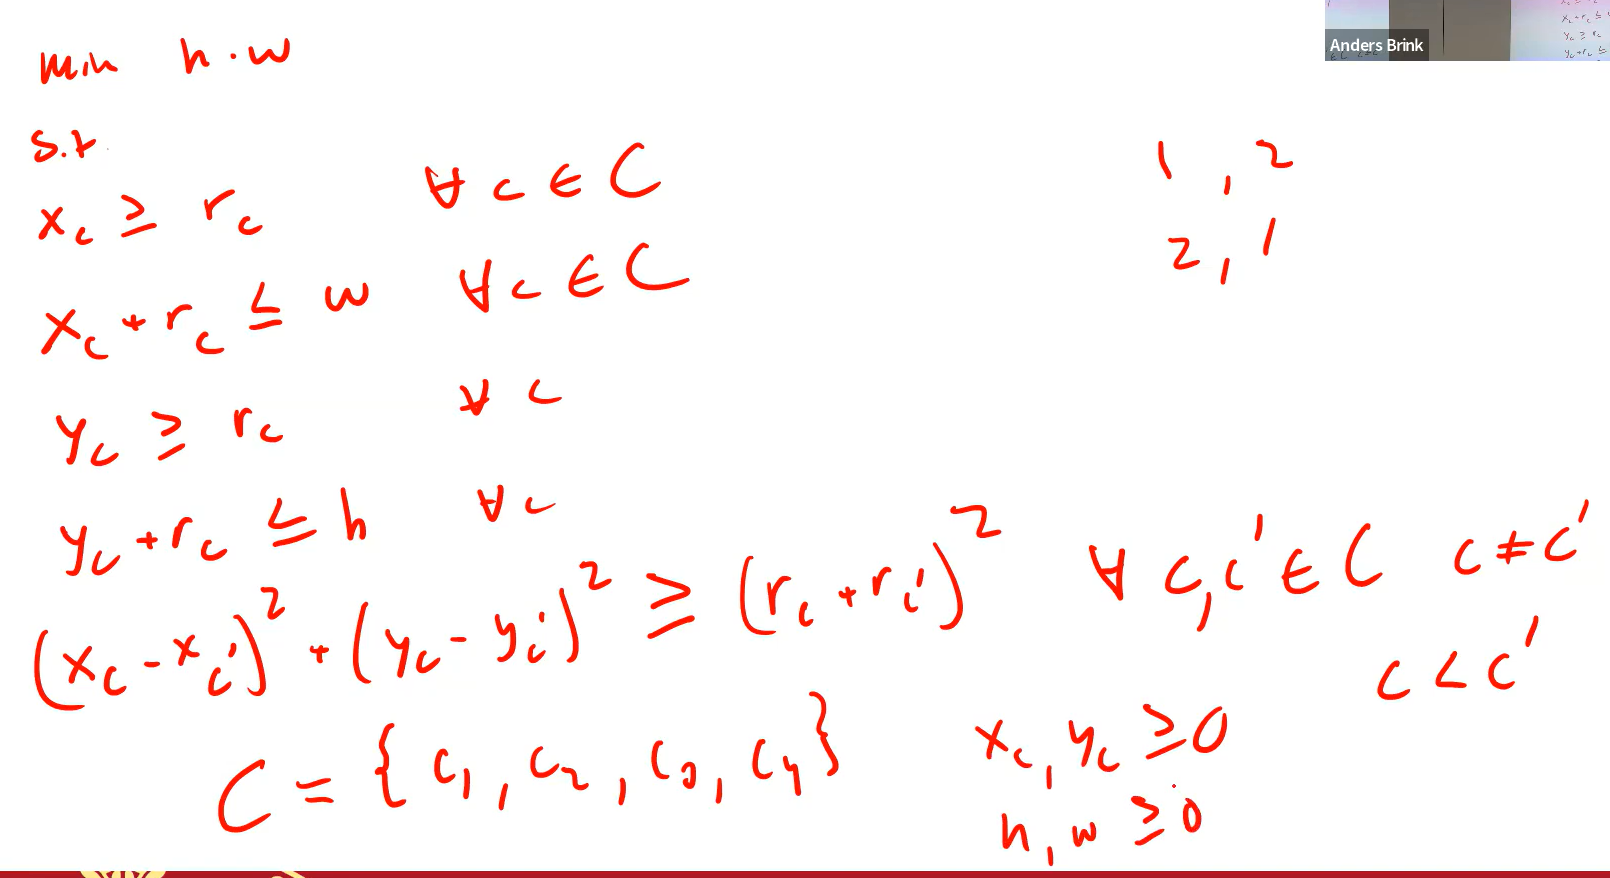

In [ ]:
#install pyomo and solvers from the IDAES proejct
#this installs several solvers like ipopt, cbc, bonmin but takes some time to run
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

In [ ]:
from pyomo.environ import *

m=ConcreteModel()
m.C =Set(initialize=['c1', "c2", "c3", "c4"])  #C:circles
m.r=Param(m.C, initialize={'c1':3, "c2":3, "c3":2, "c4":3})
m.w=Var(within=NonNegativeReals, doc="Width of rectangle")
m.h=Var(within=NonNegativeReals, doc="Height of rectangle")
m.x=Var(m.C, within=NonNegativeReals, doc="x position of a circle c")
m.y=Var(m.C, within=NonNegativeReals, doc="y position of a circle c")

m.obj=Objective(expr=m.h*m.w, sense= minimize, doc='Objective: minimize area')

def xmin_rule(m,c):
    return m.x[c]>=m.r[c]
m.xmin=Constraint(m.C, rule=xmin_rule)

def xmax_rule(m,c):
    return m.x[c]+m.r[c]<=m.w
m.xmax=Constraint(m.C, rule=xmax_rule)

def ymin_rule(m,c):
    return m.y[c]>=m.r[c]
m.ymin=Constraint(m.C, rule=ymin_rule)

def ymax_rule(m,c):
    return m.y[c]+m.r[c]<=m.h
m.ymax=Constraint(m.C, rule=ymax_rule)

def overlap_rule(m,c,cp): #cp:c prime or c' , distance between centres should be more than radiuses
  if c<cp : #to consider circles one not two times like 1:2 and 2:1
    return (m.x[c]-m.x[cp])**2+(m.y[c]-m.y[cp])**2>=(m.r[c]+m.r[cp])**2
  else:
    return Constraint.Skip
m.overlap=Constraint(m.C,m.C, rule=overlap_rule) #m.C,m.C as we consider two circles at the same time

m.pprint() # to display steps and details

1 Set Declarations
    C : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {'c1', 'c2', 'c3', 'c4'}

1 Param Declarations
    r : Size=4, Index=C, Domain=Any, Default=None, Mutable=False
        Key : Value
         c1 :     3
         c2 :     3
         c3 :     2
         c4 :     3

4 Var Declarations
    h : Height of rectangle
        Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : NonNegativeReals
    w : Width of rectangle
        Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : NonNegativeReals
    x : x position of a circle c
        Size=4, Index=C
        Key : Lower : Value : Upper : Fixed : Stale : Domain
         c1 :     0 :  None :  None : False :  True : NonNegativeReals
         c2 :     0 :  None :  None : False :  True

In [ ]:
#SOlve and selecting solver
solver=SolverFactory("ipopt") #ipopt used for non linear optimization
results=solver.solve(m,tee=True)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

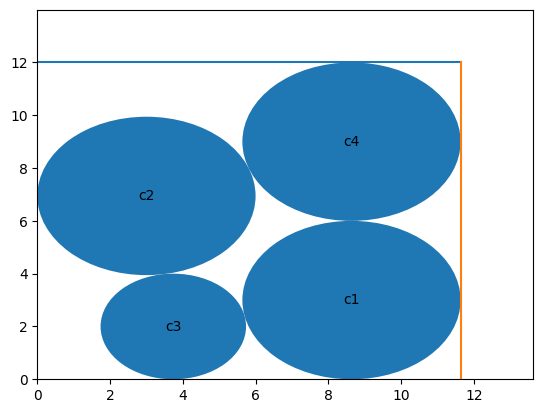

In [ ]:
#plot
import matplotlib.pyplot as plt

figure, axes=plt.subplots()

for c in m.C:
  draw_circle=plt.Circle((m.x[c].value, m.y[c].value),m.r[c])
  axes.add_artist(draw_circle)
  axes.text(m.x[c].value, m.y[c].value, c,
            horizontalalignment='center', verticalalignment='center')

plt.plot([0,m.w.value], [m.h.value, m.h.value])
plt.plot([m.w.value, m.w.value], [0,m.h.value])

plt.xlim(0, m.w.value+2)
plt.ylim(0, m.h.value+2)
plt.show()

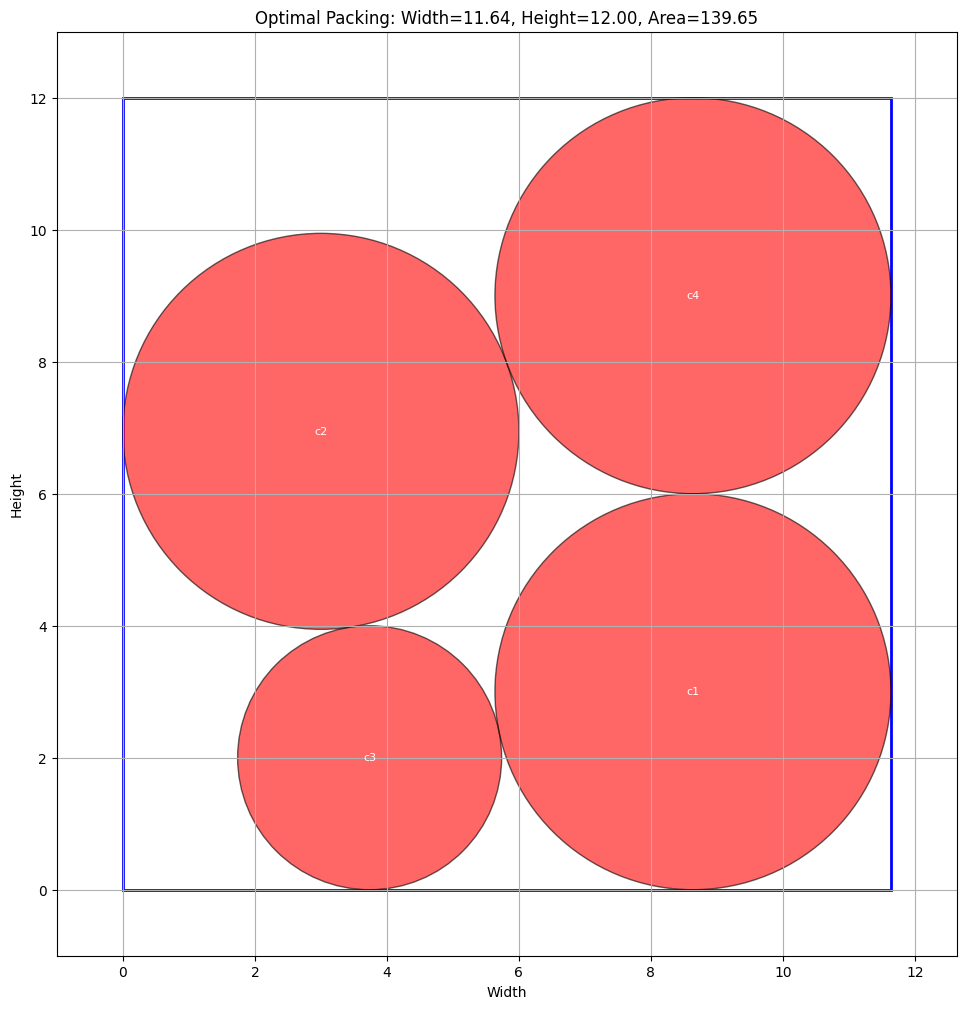

In [ ]:
# Plotting the results
import matplotlib.pyplot as plt

# Get the optimal width and height of the rectangle
optimal_w = m.w.value
optimal_h = m.h.value

fig, ax = plt.subplots(figsize=(optimal_w, optimal_h))

# Plot the bounding rectangle
bounding_box = plt.Rectangle((0, 0), optimal_w, optimal_h, fill=False, edgecolor='blue', linewidth=2)
ax.add_patch(bounding_box)

# Plot each circle
for c in m.C:
    circle_center_x = m.x[c].value
    circle_center_y = m.y[c].value
    circle_radius = m.r[c] # m.r[c] is a parameter, access its value directly
    circle = plt.Circle((circle_center_x, circle_center_y), circle_radius, fill=True, edgecolor='black', facecolor='red', alpha=0.6)
    ax.add_patch(circle)
    ax.text(circle_center_x, circle_center_y, c, ha='center', va='center', color='white', fontsize=8)

ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-1, optimal_w + 1)
ax.set_ylim(-1, optimal_h + 1)
ax.set_title(f'Optimal Packing: Width={optimal_w:.2f}, Height={optimal_h:.2f}, Area={optimal_w*optimal_h:.2f}')
plt.xlabel('Width')
plt.ylabel('Height')
plt.grid(True)
plt.show()

In [ ]:
#SOlve and selecting solver
solver=SolverFactory("couenne") # Which is not for nonlinear problem and give wrong results
results=solver.solve(m,tee=True)

Couenne 0.5.8 -- an Open-Source solver for Mixed Integer Nonlinear Optimization
Mailing list: couenne@list.coin-or.org
Instructions: http://www.coin-or.org/Couenne
couenne: 
ANALYSIS TEST: NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 139.64618        6 0.003674
Couenne: new cutoff value 1.3964618040e+02 (0.018595 seconds)
Loaded instance "/tmp/tmpvalq5f4j.pyomo.nl"
Constraints:           22
Variables:             10 (0 integer)
Auxiliaries:           31 (0 integer)

Coin0506I Presolve 78 (0) rows, 35 (-6) columns and 172 (-6) elements
Clp0006I 0  Obj 36 Primal inf 1722.3843 (42)
Clp0006I 36  Obj 36
Clp0000I Optimal - objective value 36
Clp0032I Optimal objective 36 - 36 iterations time 0.002, Presolve 0.00
Clp0000I Optimal - objective value 36
Cbc0012I Integer solution of 139.64618 found by Couenne Rounding NLP after 0 iterations and 0 nodes (0.00 seconds)
NLP Heuristic: NLP0014I             2    

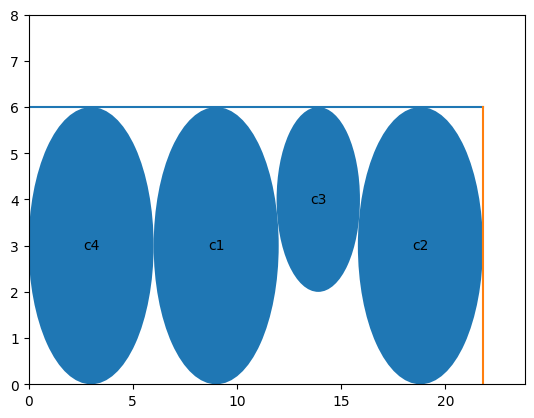

In [ ]:
#plot
import matplotlib.pyplot as plt

figure, axes=plt.subplots()

for c in m.C:
  draw_circle=plt.Circle((m.x[c].value, m.y[c].value),m.r[c])
  axes.add_artist(draw_circle)
  axes.text(m.x[c].value, m.y[c].value, c,
            horizontalalignment='center', verticalalignment='center')

plt.plot([0,m.w.value], [m.h.value, m.h.value])
plt.plot([m.w.value, m.w.value], [0,m.h.value])

plt.xlim(0, m.w.value+2)
plt.ylim(0, m.h.value+2)
plt.show()

1 Set Declarations
    C : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    6 : {'c1', 'c2', 'c3', 'c4', 'nc1', 'nc2'}

1 Param Declarations
    r : Size=6, Index=C, Domain=Any, Default=None, Mutable=False
        Key : Value
         c1 :     3
         c2 :     3
         c3 :     2
         c4 :     3
        nc1 :     5
        nc2 :    10

4 Var Declarations
    h : Height of rectangle
        Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : NonNegativeReals
    w : Width of rectangle
        Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  None :  None : False :  True : NonNegativeReals
    x : x position of a circle c
        Size=6, Index=C
        Key : Lower : Value : Upper : Fixed : Stale : Domain
         c1 :     0 :  None :  None : False :  True : NonNegativeRea

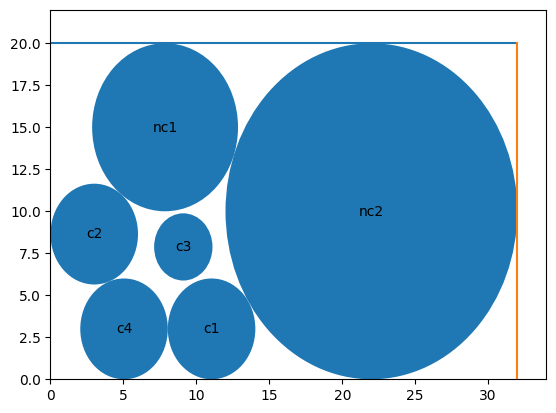

In [ ]:
#Now add three more circles to see what happen
from pyomo.environ import *

m=ConcreteModel()
m.C =Set(initialize=['c1', "c2", "c3", "c4", 'nc1', 'nc2'])  #C:circles
m.r=Param(m.C, initialize={'c1':3, "c2":3, "c3":2, "c4":3, 'nc1':5, 'nc2':10})
m.w=Var(within=NonNegativeReals, doc="Width of rectangle")
m.h=Var(within=NonNegativeReals, doc="Height of rectangle")
m.x=Var(m.C, within=NonNegativeReals, doc="x position of a circle c")
m.y=Var(m.C, within=NonNegativeReals, doc="y position of a circle c")

m.obj=Objective(expr=m.h*m.w, sense= minimize, doc='Objective: minimize area')

def xmin_rule(m,c):
    return m.x[c]>=m.r[c]
m.xmin=Constraint(m.C, rule=xmin_rule)

def xmax_rule(m,c):
    return m.x[c]+m.r[c]<=m.w
m.xmax=Constraint(m.C, rule=xmax_rule)

def ymin_rule(m,c):
    return m.y[c]>=m.r[c]
m.ymin=Constraint(m.C, rule=ymin_rule)

def ymax_rule(m,c):
    return m.y[c]+m.r[c]<=m.h
m.ymax=Constraint(m.C, rule=ymax_rule)

def overlap_rule(m,c,cp): #cp:c prime or c' , distance between centres should be more than radiuses
  if c<cp : #to consider circles one not two times like 1:2 and 2:1
    return (m.x[c]-m.x[cp])**2+(m.y[c]-m.y[cp])**2>=(m.r[c]+m.r[cp])**2
  else:
    return Constraint.Skip
m.overlap=Constraint(m.C,m.C, rule=overlap_rule) #m.C,m.C as we consider two circles at the same time

m.pprint() # to display steps and details


#SOlve and selecting solver
solver=SolverFactory("ipopt") #ipopt used for non linear optimization
results=solver.solve(m,tee=True)



#plot
import matplotlib.pyplot as plt

figure, axes=plt.subplots()

for c in m.C:
  draw_circle=plt.Circle((m.x[c].value, m.y[c].value),m.r[c])
  axes.add_artist(draw_circle)
  axes.text(m.x[c].value, m.y[c].value, c,
            horizontalalignment='center', verticalalignment='center')

plt.plot([0,m.w.value], [m.h.value, m.h.value])
plt.plot([m.w.value, m.w.value], [0,m.h.value])

plt.xlim(0, m.w.value+2)
plt.ylim(0, m.h.value+2)
plt.show()

Installing pyomo and the cbc solver. We will mainly deal with MILP problem so you may save 10 seconds this way

```
try:
  from pyomo.environ import *
except:
  !pip install -q pyomo
  !apt-get install -y -qq coinor-cbc
```

An alternative solver to CBC is Highs (see https://highs.dev/). This may perform better and can also solve quadratic problems. To install pyomo and Highs you can use the following example. Note, the solver is accessed using some special functions.

```
try:
  import pyomo.environ as pyo
except:
  !pip install pyomo
  !pip install highspy

import pyomo.environ as pyo
from pyomo.contrib.appsi.solvers.highs import Highs
model = pyo.ConcreteModel()
model.x = pyo.Var([1, 2], within=pyo.NonNegativeIntegers)
model.c1 = pyo.Constraint(expr=2 * model.x[1] + 3 * model.x[2] <= 12)
model.c2 = pyo.Constraint(expr=2 * model.x[1] + model.x[2] <= 6)
model.obj = pyo.Objective(expr=5 * model.x[1] + 4 * model.x[2], sense=pyo.maximize)
solver = Highs()
solver.highs_options = {"time_limit": 10}
res = solver.solve(model)  
```

In [ ]:
#convenient (but not good Python programming practice)
from pyomo.environ import *
mod=ConcreteModel()



```
#better practice, but add a little extra characters to the code
#if you use this, delete the one above, and also modify the import in the try-section.
import pyomo.environ as pyo
mod = pyo.ConcreteModel() #we now explicitely can see that ConcreteModel is a data structure that is not a part of the Python core

#you then need to write
mod = pyo.ConcreteModel()
mod.pc = pyo.Param(..)
mod.x = pyo.Var(within = pyo.Integer, doc='an integer variabel')
mod.c = pyo.Constraint()
mod.myobjective = pyo.Objective(... sense=pyo.maximize)
solver = pyo.SoverlFactory()

```



Using cbc in colab with a time restriction of 10 s


```
# This is formatted as code
solver = SolverFactory("cbc", executable="/usr/bin/cbc")
solver.options["sec"]=10
results = solver.solve(mod,tee=True)
```





In [ ]:
#better practice, but add a little extra characters to the code
#if you use this, delete the one above, and also modify the import in the try-section.
import pyomo.environ as pyo
mod = pyo.ConcreteModel() #we now explicitely can see that ConcreteModel is a function that is not a part of the Python core

In [ ]:
solver = SolverFactory("cbc", executable="/usr/bin/cbc")
solver.options["sec"]=10
results = solver.solve(mod,tee=True)

Failed to set executable for solver cbc. File with name=/usr/bin/cbc either does not exist or it is not executable. To skip this validation, call set_executable with validate=False.
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pyomo/opt/base/solvers.py", line 161, in __call__
    opt = self._cls[_name](**kwds)
          ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pyomo/solvers/plugins/solvers/CBCplugin.py", line 88, in __init__
    super(CBCSHELL, self).__init__(**kwds)
  File "/usr/local/lib/python3.12/dist-packages/pyomo/opt/solver/shellcmd.py", line 66, in __init__
    self.set_executable(name=executable, validate=validate)
  File "/usr/local/lib/python3.12/dist-packages/pyomo/opt/solver/shellcmd.py", line 115, in set_executable
    raise ValueError(
ValueError: Failed to set executable for solver cbc. File with name=/usr/bin/cbc either does not exist or it is not executable. To skip this validation, call set_executa

RuntimeError: Attempting to use an unavailable solver.

The SolverFactory was unable to create the solver "cbc"
and returned an UnknownSolver object.  This error is raised at the point
where the UnknownSolver object was used as if it were valid (by calling
method "solve").

The original solver was created with the following parameters:
	executable: /usr/bin/cbc
	type: cbc
	_args: ()
	options: {'sec': 10}

Here are some options for bonmin



```
#
solver = SolverFactory("bonmin")
#if you need to specify path so solver:
solver = SolverFactory("bonmin",executable="/content/bonmin")

#only use one of these (or none, then default, which is B-Hyb)
solver.options["bonmin.algorithm"]="B-BB" #brach&bound
solver.options["bonmin.algorithm"]="B-OA" #outer approximation
solver.options["bonmin.algorithm"]="B-QG" # Quesada and Grossmann's branch-and-cut algorithm
solver.options["bonmin.algorithm"]="B-Hyb" #hybrid outer-approximation based branch-and-cut algorithm

#some other solver options, atleast the time limit on the solver is useful
solver.options["bonmin.time_limit"]=120
solver.options["max_iter"]=50000 #max iterations for ipopt, default 3000

#calling solver, tee=False gives quite output on the progress, you probably want to use tee=True
results = solver.solve(m,tee=False)
```





Other solvers (ipopt and couenne are like bonmin in /content/ becasue they are installed in ste same way in colab. Use of of the following:
```
#
solver = SolverFactory("ipopt",executable="/content/ipopt")
solver = SolverFactory("couenne",executable="/content/couenne")

results = solver.solve(m,tee=False)
```

# Using files with in colab
The colab machine is a virtual machine and created eash time you want to run code in it. This gives some problems when you like to work with files. Here are some options for working with files

1. Upload the files from the notbook with upload. Click on the folder icon to the left to open this view. You can now drag and drop from your own computer

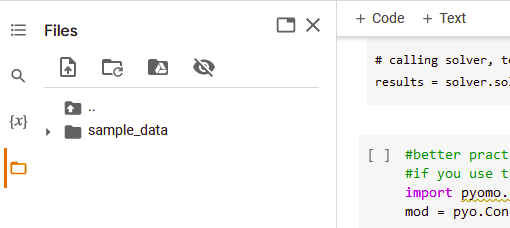

2. Upload files to an active virtual machine with code
```
#this will give you a widget for selecting files to upload, must be done each time you start the virtual machine
from google.colab import files
uploaded = files.upload()
```

3. Have an url to your file and open with the pandas package, works well for excel file.

In this course, the easiest way for you to reach a file via an url, is to upload it to your personal ÅA hope page area. On a windows machine this is easy. Mount this was a drive in windows. The area you should mount is

\\wwwusers.abo.fi\wwwusers\your_username

Then copy the file there and you can read it in. If you have the file in the part you can use:

```
import pandas as pd
df = pd.read_excel('myexelfile.xlsx')
```




An example of a MILP problem (A book shelf packing problem)

In [ ]:

#author: abrink

#Glass cutting (or packing into shelves)
#http://www1.utt.fr/mosim01/pdf/ARTICLE-093.pdf

#Model assumes that all items are sorted in descended height order
#The problem is to have the most valuable shelf, more items
#available than we can fit to the shelf


from pyomo.environ import *
import matplotlib.pyplot as plt
import pandas as pd

#create a dict of unsorted rectangles to choose between
d = {'h': [3,2,4,3,5,2,1,5,3,2,1,5,3,6,3,2], 'w': [3,4,2,1,4,3,3,2,5,5,7,4,1,2,3,4]}

#create a dataframe for sorting etc
df = pd.DataFrame(data=d)
#sort the data in falling height
df = df.sort_values(by=['h'], ascending=False)
#reset the index key
df = df.reset_index(drop=True)

#We create the model object, here called "m"
m=ConcreteModel()

#Create a set of items
m.n = Param(initialize=len([n for n in df.set_index('h').index.values if pd.notnull(n)]),doc='number of items available')
m.itms=RangeSet(m.n)

#Create parameters that defines size and cost of items (as w*h)
#These are picked out from the sorted dataframe
#Name "items" reserved, no mispelling
h={}
w={}
p={}
for j in m.itms:
    h[j]=df.loc[j-1].at['h']
    w[j]=df.loc[j-1].at['w']
    p[j]=h[j]*w[j]

m.h = Param(m.itms,initialize=h,doc='Height of items')
m.w = Param(m.itms,initialize=w,doc='Width of items')
m.p = Param(m.itms,initialize=h,doc='Cost/Profit of items')

m.W = Param(initialize=6,doc='Width of shelf')
m.H = Param(initialize=10,doc='Total height of shelf rack')



#Items cannot be places on a shelf with lower index; we do not need to define these for the variable
#This to prevent mistakes if the objctive is changed.
si = []
for j in m.itms:
    for k in m.itms:
        if k <= j:
            foo_tuple = (j, k)
            si.append(foo_tuple)
m.sparsex=Set(initialize=si,doc='Set with valid j,k index for x')
m.x = Var(m.sparsex,within=Binary,doc='Variable x_jk, true if item j is in shelf number k')

#THe non-sparse version of the variable, contains unneccessary combinations
#m.x = Var(m.itms,m.itms,within=Binary,doc='Variable x_jk, true if item j is in shelf number k')

#Object function, value of picked items. Highest item can only be on lowest shelf,
#second highest on lowest and second lowest and so on. As many shelfs as items possible
m.obj=Objective(expr=sum(m.p[j]*m.x[j,k] for j in m.itms for k in m.itms if k <= j),sense=maximize)

def once_rule(m,j):
    return sum(m.x[j,k] for k in m.itms if k <= j) <= 1
m.once=Constraint(m.itms,rule=once_rule,doc='An item can only be picked once')

def shellwidth_rule(m,k):
    if k < len(m.itms):
        return sum(m.w[j]*m.x[j,k] for j in range(k+1,m.n+1)) <= (m.W-m.w[k])*m.x[k,k]
    else:
        return Constraint.Skip
m.shellw=Constraint(m.itms,rule=shellwidth_rule,doc='Widht of items smaller than available space, item k always first on shelf k')

m.toth=Constraint(expr=sum(m.h[k]*m.x[k,k] for k in m.itms) <= m.H,doc='Hight of used shelf-layers smaller than alowed rack height')

#Specify solver
solver = SolverFactory("cbc")

#Verbous solving
results = solver.solve(m,tee=True)

#Probably clumpsy, need to keep track of the lower left corner of the
#rectangles. Only addition in hight if a new shelf is initialized (xkk=1)
figure, axes = plt.subplots()
th=0
ah=0
for k in m.itms:
    tw=0
    th=th+ah
    ah=0
    for j in m.itms:
        if j >= k and m.x[j,k].value:
            p = plt.Rectangle((tw,th), m.w[j],m.h[j], fill=True,edgecolor='black')
            axes.add_artist(p)
            axes.text(tw+m.w[j]/2, th+m.h[j]/2, j,
                      horizontalalignment='left', verticalalignment='top')
            tw+=m.w[j]
            if j == k:
                ah=m.h[j]

axes.set_aspect(1)

plt.xlim(0,m.W.value)
plt.ylim(0,m.H.value)
plt.show()


In [ ]:
m.toth.pprint()